In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import cityImage as ci

from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

**Ininitialising path, names, etc.**

In [2]:
city_name = 'Barcelona'
epsg = 2062
crs = 'EPSG:'+str(epsg)
place = 'Barcelona, Spain'

## Nodes and Dual Network From OSM data
### Download and preparation
Choose the name of the place that represent your case-study area. When the case-study area does not coincide with the entire extension of a city, it is suggested to include the case-study area's surroundings (e.g. buffer of 2000 mt from the centre of the area, depending on its extension) so to avoid the edge effect when computing the centrality measures.

Choose between the following methods:
* `OSMplace`, providing an OSM place name (e.g. City).
* `OSMpolygon`, provide a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter (which is otherwise not necessary)

In [3]:
download_method = 'distance_from_address'
distance = 5000

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'walk', distance = distance, epsg = epsg)

### Cleaning and simplyfing the Street Network

At the end of the previous section two files are obtained: nodes and edges (vertexes and links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle (through boolean parameters):
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* `remove_islands`: Disconnected islands.
* `dead_ends` Dead-end street segments.
* `self_loops` Self-Loops.
* `same_vertexes_edges` Edges with same from-to nodes, but different geometries.
* `fix_topology` This creates nodes and breaks street segments at intersections. It is primarily useful for poorly formed datasets (usually OSM deerived networks are topologically correct). It accounts for segments classified as bridges or tunnels in OSM.

`same_vertexes_edges` handles edges with same pair of u-v nodes but different geometries. When `True`, it derives a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the shorter segment is deleted.

In [4]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = True,
                            same_vertexes_edges = True, self_loops = True, fix_topology = False)

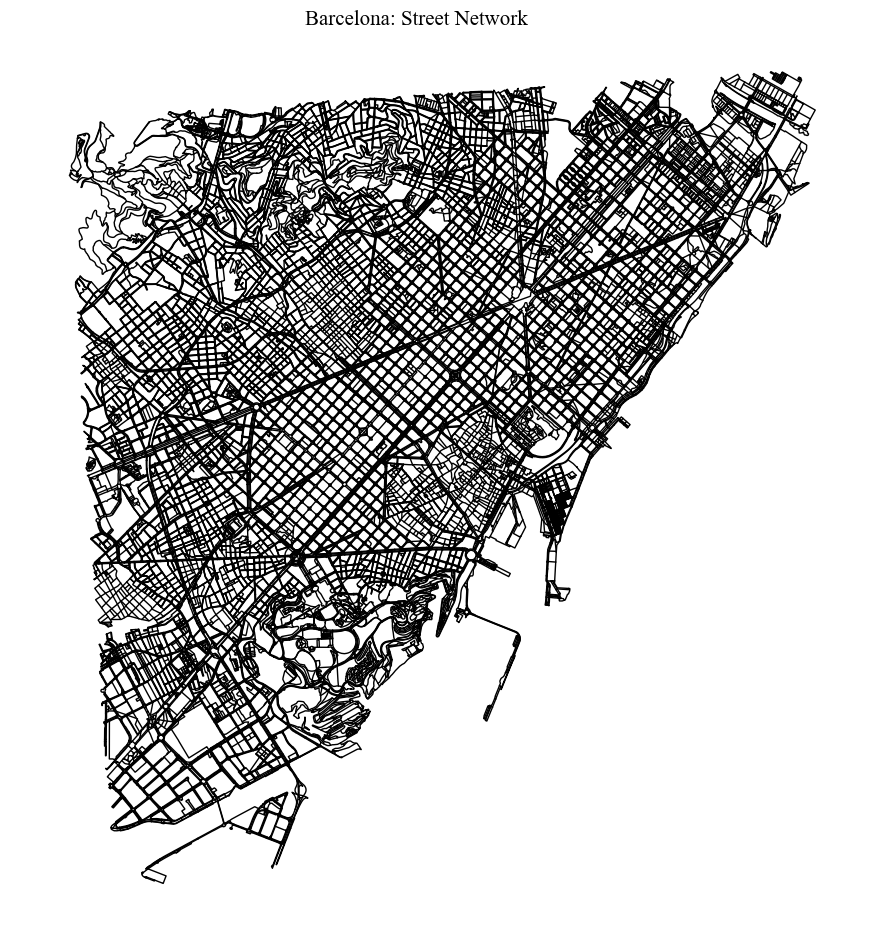

In [5]:
plot = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network',
                   color = 'black')

### Node centrality
Betweenness centrality is used to model nodes' hierarchies and identify salient nodes in the network.

In [6]:
# Obtaining the graph from the case-study area and computing the centrality measures
graph = ci.graph_fromGDF(nodes_graph, edges_graph)

# betweenness centrality
Bc_Rd = ci.calculate_centrality(nx_graph = graph, measure ='betweenness', weight='length')
nodes_graph['Bc_Rd'] = nodes_graph.nodeID.map(Bc_Rd)

#### Visualisation

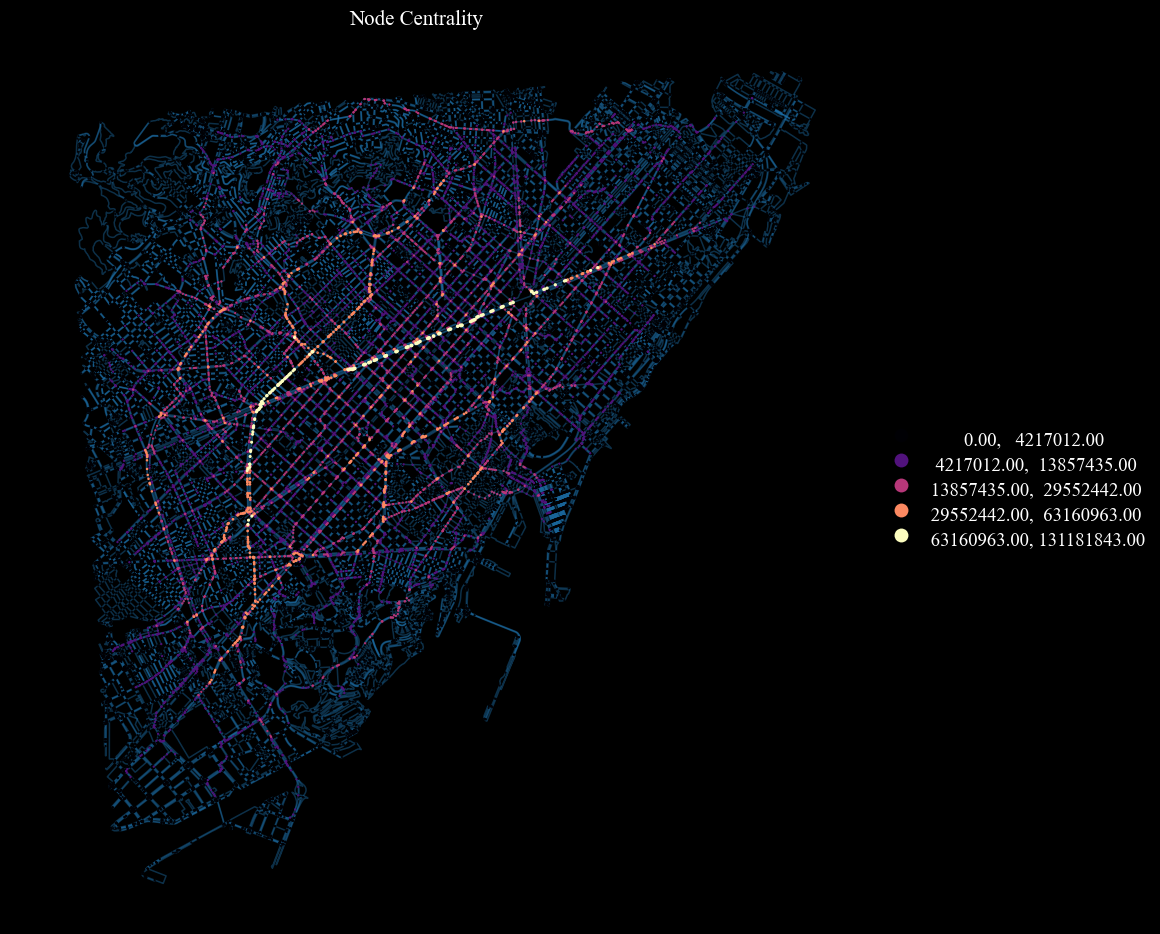

In [19]:
fig = ci.plot_gdf(nodes_graph, column = 'Bc_Rd', title =  "Node Centrality", cmap = 'magma', classes = 5, scheme = 'natural_breaks',
            geometry_size_factor = 3, figsize = (10, 10), base_map_gdf = edges_graph, base_map_zorder = 0, 
            legend = True)

### Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. This process allows taking advantage of angular relationships in centrality measures computation and other network operations.

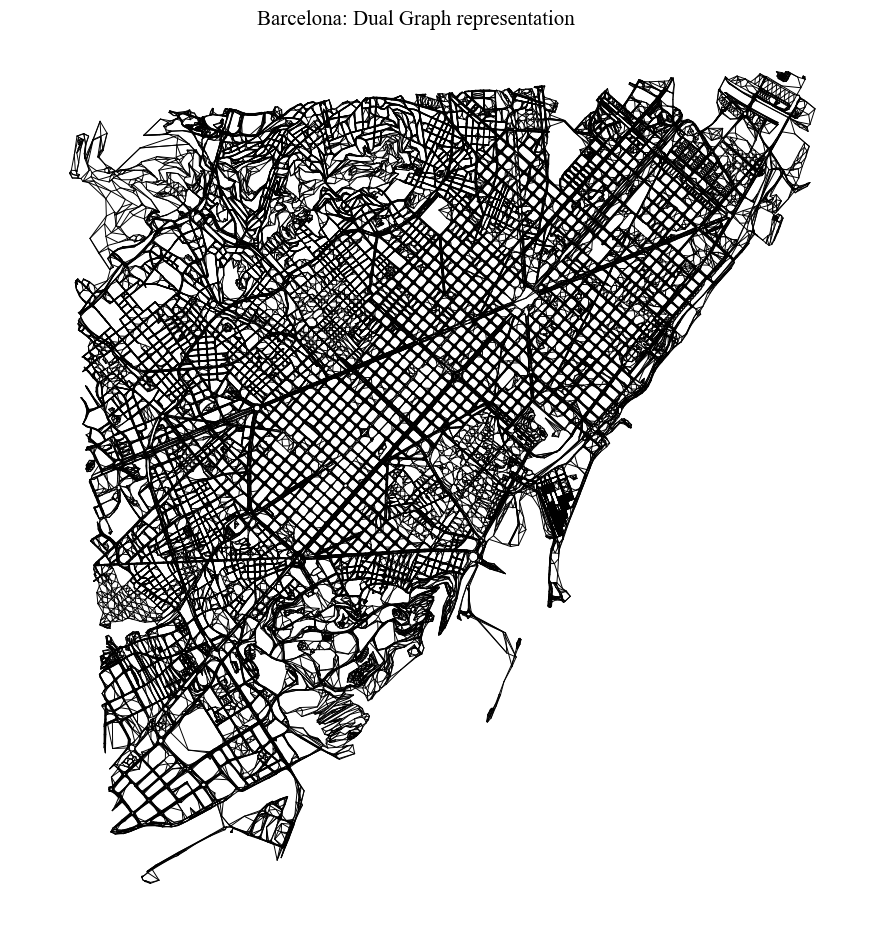

In [8]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
plot = ci.plot_gdf(edgesDual_graph, black_background = False, figsize = (10,10), title = city_name+': Dual Graph representation', 
             color = 'black', geometry_size = 0.7)

## Districts Identification
### Download and preparation

In [9]:
place = 'Barcelona, Spain'
download_method = 'OSMplace'
distance = None

nodes_graph_drive, edges_graph_drive = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodesDual_graph_drive, edgesDual_graph_drive = ci.dual_gdf(nodes_graph_drive, edges_graph_drive, epsg)

# creating the dual_graph
dual_graph_drive = ci.dual_graph_fromGDF(nodesDual_graph_drive, edgesDual_graph_drive)

### Computation

In [10]:
weights = ['length', 'rad', None]
districts = edges_graph_drive.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph_drive, districts, weight = weight)

#### Visualisation

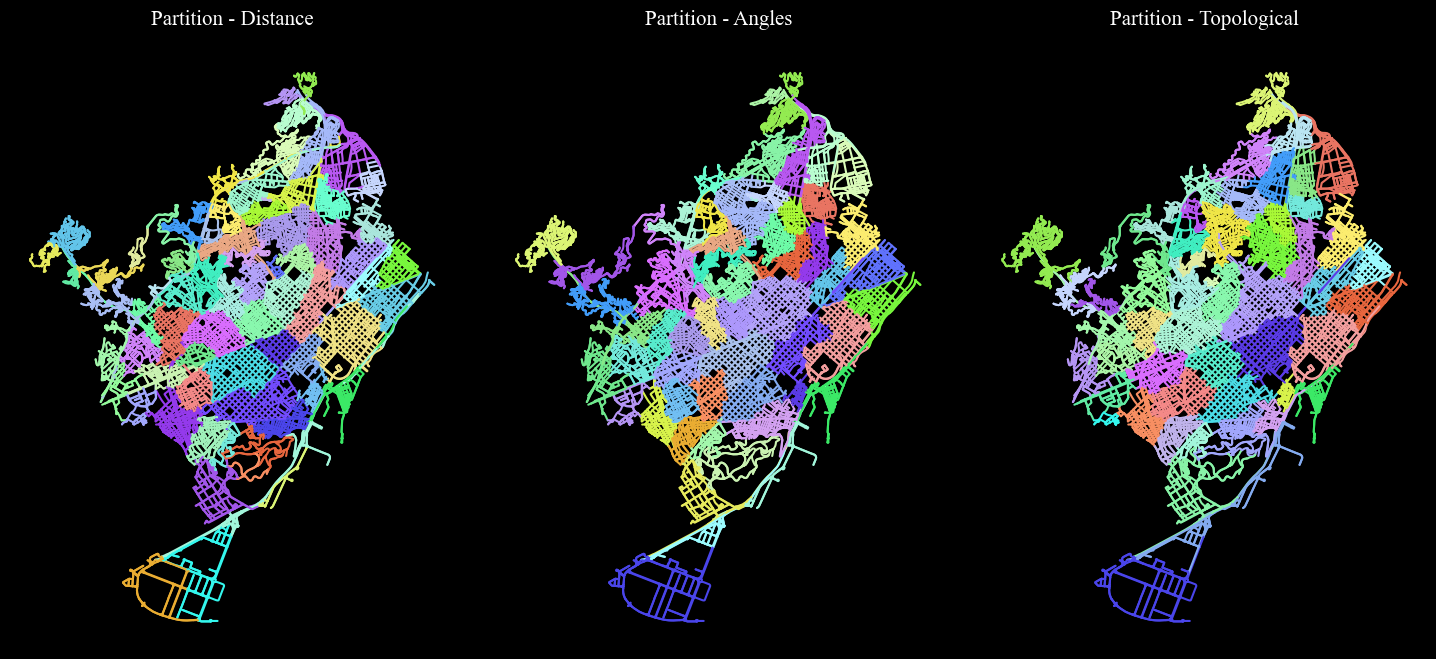

In [11]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

### Assigning Regions to the Pedestrian Network

In [13]:
# choosing the type of partition to be used
column = 'p_rad'
min_size_district = 10
dc = dict(districts[column].value_counts())

## ignore small portions
to_ignore = {k: v for k, v in dc.items() if v <= min_size_district} 
tmp = districts[~((districts[column].isin(to_ignore))| (districts[column] == 999999))].copy()

partitions = ci.polygonise_partitions(tmp, column)
nodes_graph = ci.district_to_nodes_from_polygons(nodes_graph, partitions, column)
nodes_graph[column] = nodes_graph[column].astype(int)
nodes_graph = ci.amend_nodes_membership(nodes_graph, edges_graph, column, min_size_district)
   
# assigning gateways
nodes_graph = ci.find_gateways(nodes_graph, edges_graph, column)

#### Visualisation

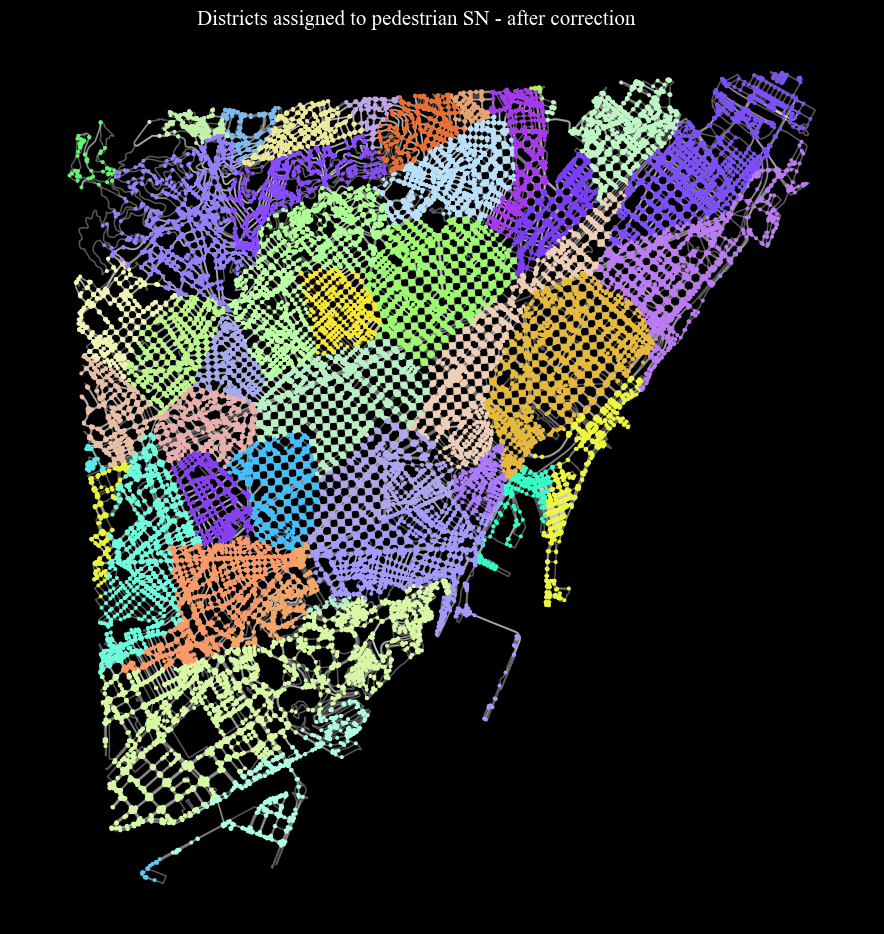

In [14]:
nodes_graph['district'] = nodes_graph[column].astype(int)
cmap = ci.rand_cmap(nlabels = len(nodes_graph['district'].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph, column = column, title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, geometry_size = 3.5, base_map_gdf = edges_graph, base_map_color = 'white', 
                  base_map_alpha = 0.35, black_background = True, legend = False, figsize = (10,10))

## Barrier Identification
### Download and preparation

In [20]:
download_method = 'OSMplace'
place = "Barcelona, Spain"
road_barriers = ci.road_barriers(place = place, download_method = download_method, epsg= epsg,
                                 include_primary = True, include_secondary = False)
water_barriers = ci.water_barriers(place = place, download_method = download_method, epsg= epsg)
railway_barriers = ci.railway_barriers(place = place, download_method = download_method, epsg= epsg)
park_barriers = ci.park_barriers(place = place, download_method = download_method, epsg= epsg, min_area = 100000)

barriers = pd.concat([road_barriers, water_barriers, railway_barriers, park_barriers], ignore_index=True)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

### Visualisation

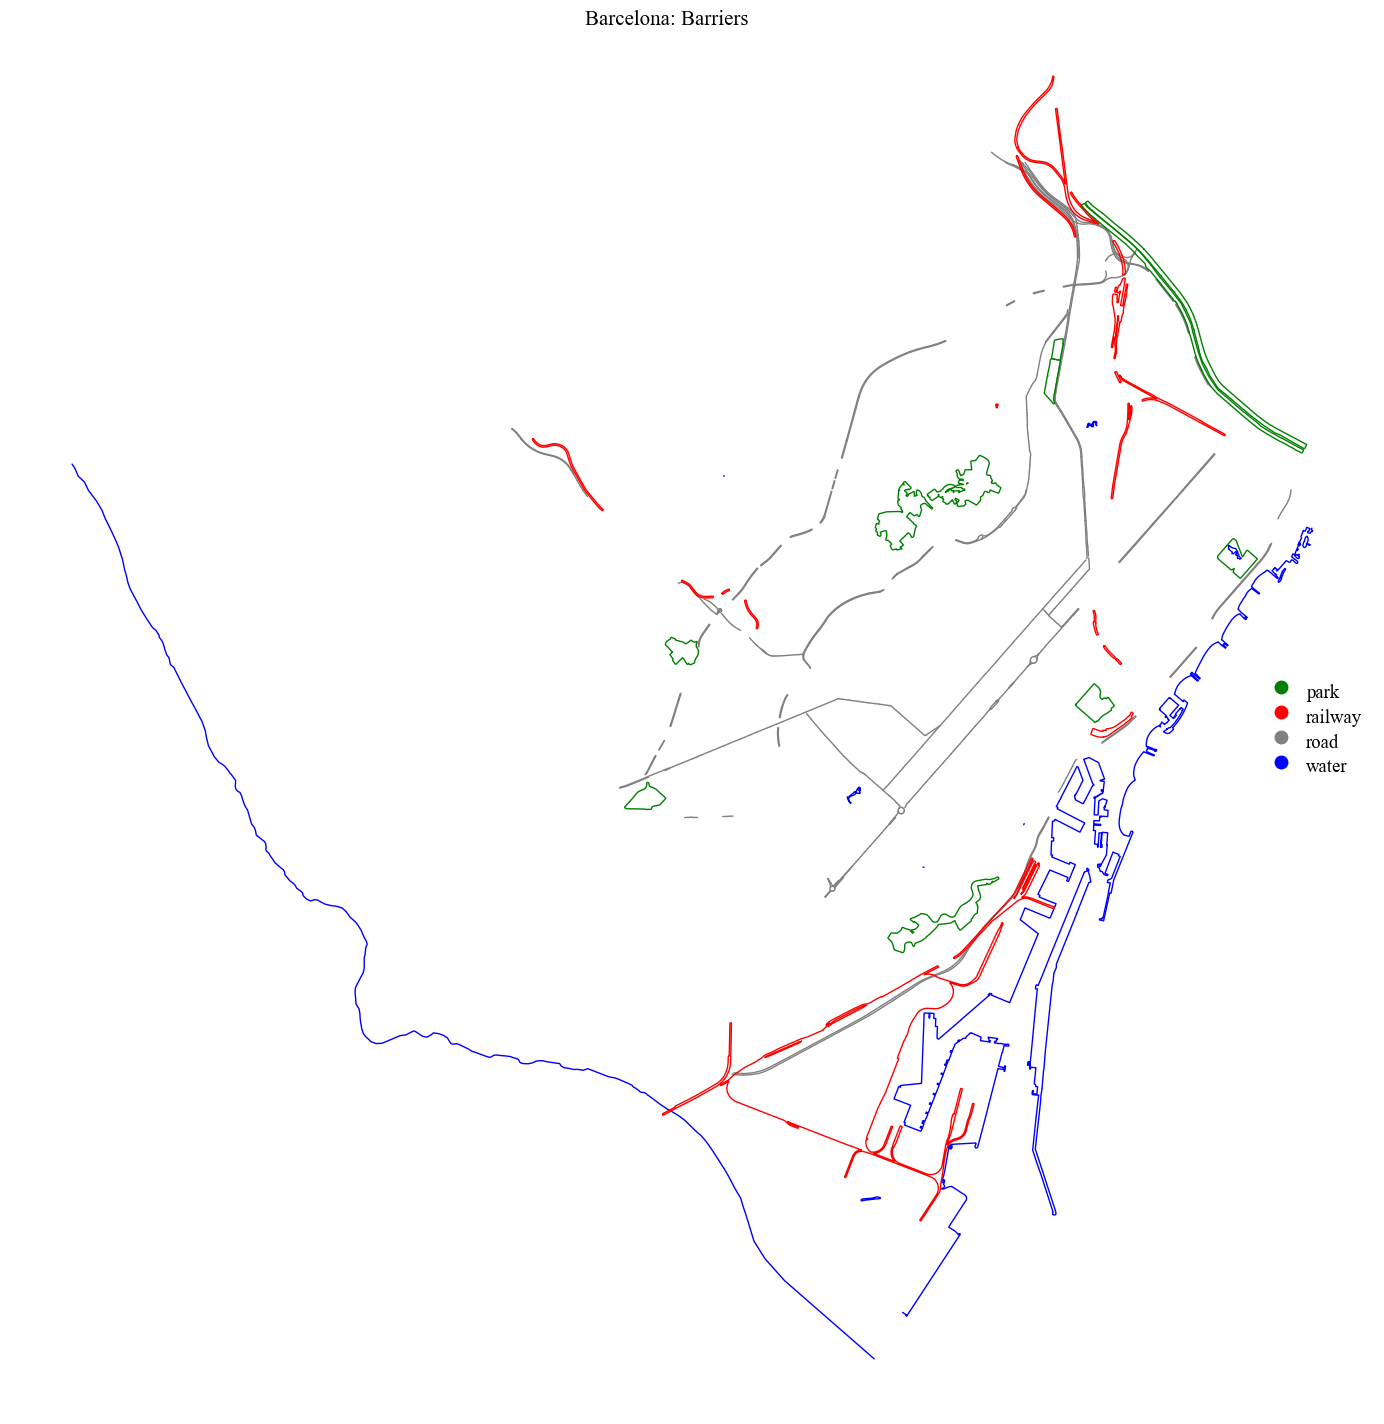

In [21]:
from matplotlib.colors import LinearSegmentedColormap

barriers.sort_values(by = 'barrier_type', ascending = False, inplace = True)  
colors = ['green', 'red', 'gray', 'blue']

cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(gdf = barriers, column = 'barrier_type', black_background = False, title = city_name+': Barriers', 
                  legend = True, cmap = cmap)

### Incorporating Barriers into the Street Network

In [22]:
# clipping barriers to case study area
envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(edges_graph.unary_union.envelope)]

# Street Segments Along and Within Positive Barriers
sindex = edges_graph.sindex
# rivers
edges_graph = ci.along_water(edges_graph, barriers_within)
# parks
edges_graph = ci.along_within_parks(edges_graph, barriers_within)
# altogheter
edges_graph['p_barr'] = edges_graph['a_rivers']+edges_graph['w_parks']
edges_graph['p_barr'] = edges_graph.apply(lambda row: list(set(row['p_barr'])), axis = 1)

# Street Segments Along Negative Barriers
tmp = barriers_within[barriers_within['barrier_type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: ci.barriers_along(row['edgeID'], edges_graph, tmp, sindex,
                                            offset = 25), axis = 1)

# Street Segments Crossing any kind of barrier but parks: Structuring Barriers
edges_graph = ci.assign_structuring_barriers(edges_graph, barriers_within)

# converting list fields to string
to_convert = ['a_rivers', 'w_parks','n_barr', 'p_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: 
    edges_graph_string[column] = edges_graph_string[column].astype(str)

## Saving

In [27]:
nodesDual_graph.head()

edgeID  u      v  key               length                      name  \
0       0  0  19942    0                 9.33  Passeig de Joan de Borbó   
1       1  0  49749    0                 4.33                       NaN   
2       2  0  19941    0                56.94  Passeig de Joan de Borbó   
3       3  1   5874    0                28.28  Passeig de Joan de Borbó   
4       4  1   5877    0                31.24  Passeig de Joan de Borbó   

       highway  oneway lanes  bridge  tunnel                    intersecting  \
0  residential   False     3       0       0      [0, 1, 2, 5, 31027, 65263]   
1      service   False   NaN       0       0         [0, 1, 2, 71236, 71239]   
2  residential   False     3       0       0  [0, 1, 2, 65255, 65258, 65261]   
3  residential   False     2       0       0         [3, 4, 5, 19840, 19841]   
4  residential   False     2       0       0         [3, 4, 5, 19841, 19847]   

                         geometry                    x                    y  
0  POINT (1090736.771 768182.264)           1090736.77            768182.26  
1  POINT (1090732.907 768186.746)           1090732.91            768186.75  
2  POINT (1090736.021 768215.055)           1090736.02            768215.05  
3  POINT (1090748.994 768143.166)           1090748.99            768143.17  
4  POINT (1090758.491 768144.477)           1090758.49            768144.48

In [28]:
output_path = '../output/'+city_name
nodes_graph.to_file(output_path+"_nodes.gpkg", driver="GPKG")
edges_graph_string.to_file(output_path+"_edges.gpkg", driver="GPKG")
nodesDual_graph.drop("intersecting", axis = 1).to_file(output_path+"_nodesDual_graph.gpkg", driver="GPKG")
edgesDual_graph.to_file(output_path+"_edgesDual_graph.gpkg", driver="GPKG")
nodes_graph_drive.to_file(output_path+"_nodes_drive.gpkg", driver="GPKG")
edges_graph_drive.to_file(output_path+"_edges_drive.gpkg", driver="GPKG")